In [1]:
# Тут будет драфт. В него не будут входить всякие красивости

# 1. Импорты и загрузка файлов
# 1.0. Импорты
import pandas as pd
import numpy as np
import pathlib as pth
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import seaborn.objects as so

%matplotlib inline


# Файлы
data_dir = pth.Path(r'c:\DATA\DOC\_Personal\учеба\GITHUB\sf_44\sf_44\data')
events_file = data_dir/r'7_4_Events.csv'
purchase_file = data_dir/r'7_4_Purchase.csv'

# Последовательности
levels_arranged = ('easy', 'medium', 'hard')
events_arranged = ('registration', 'tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase')
tutorial_arranged = ('not started', 'not finished', 'finished')


# Функции общего назначения
# Краткое описание датафрейма в удобной мне форме
def df_describe(df):
    return pd.DataFrame\
    ({  'dtype':        df.dtypes
        , 'distinct':   df.nunique()
        , 'empty':      df.isna().sum()
    })

# "Сплющивание" многоуровневых столбцов
def df_flatten_headers (df):
    df.columns = \
        [':'.join([x for x in col]) 
        for col in df.columns.to_flat_index()
        ]
    return df

In [2]:
# Приступаем к выполнению задания
# 1.1. Читаем основной лог
events_df = pd.read_csv ( events_file,
      dtype = {'selected_level': 'category',
              'id': 'Int64', 'tutorial_id': 'Int64', 'user_id': 'Int64'}
    )
events_df['start_time'] = pd.to_datetime \
        (   events_df['start_time'],
            format='%Y-%m-%dT%H:%M:%S', errors='coerce'
        )

# 1.2. Читаем файл про покупки
purchase_df = pd.read_csv ( purchase_file,
     dtype =  {'id': 'Int64', 'user_id': 'Int64',
               'amount': 'float64'}
    )
purchase_df['event_datetime'] = pd.to_datetime \
        (   purchase_df['event_datetime'],
            format='%Y-%m-%dT%H:%M:%S', errors='coerce'
        )

In [3]:
# 4. Фильтрация и соединение исходных данных
# 3.1. Формируем выборку пользователей по условию задания
filtering_sample = ( events_df
    .query (f"event_type=='registration' & start_time.dt.year==2018")
    ['user_id'].unique ()
)

# 3.2 Фильтруем и слегка подобрабатываем датафреймы
events_df_filtered = ( events_df
    .query (f"user_id in @filtering_sample")
    .rename (columns={'id': 'event_id'})
)

purchase_df_filtered = ( purchase_df
    .query (f"user_id in @filtering_sample")
    .rename (columns={'id': 'purchase_id', 'event_datetime': 'start_time'})
    .assign (**{'event_type': 'purchase'})
)

# 3.3 Соединяем. Вот с этим мы будем работать
events_combined = \
(   pd.concat( [events_df_filtered, purchase_df_filtered], sort=False )
    .reset_index (drop=True)
    .sort_values (by='start_time')
    .astype
    ({  'selected_level':   pd.api.types.CategoricalDtype(categories=levels_arranged, ordered=True)
        , 'event_type':     pd.api.types.CategoricalDtype(categories=events_arranged, ordered=True)
    })
)

# Получился датафрейм следующего формата:
# print ('events_combined')
# display (df_describe (events_combined))

In [4]:
# Подготовка к заполнению основной таблицы:
# ad-hoc функции для заполнения параметров

# Максимальный этап, до которого дошел пользователь
max_event_per_user = \
(events_combined
    .groupby (['user_id'],as_index=False)
    ['event_type'].max()
    .rename (columns={'event_type':'last_event'})
)

# Время прохождения этапов:
# 0. Дано: 
# * Задана очередность типов событий (списком).
# * Для каждого пользователя получено время события каждого типа (пусто, если не проходил)
# * За время события берется время ПЕРВОГО прохождения события данным пользователем (первого начала обучения, первого конца обучения)
# 1. Каждому событию сопоставлено время предыдущего (по заданному выше порядку очередности) события, если непосредственно предшествующее отсутствует - берется ближайшее доступное
# Т.е. если перед выбором уровня не было закончено обучение - берется начало обучения, если нет начала - берется регистрация.

# 
def get_event_gap (df):
    last_event_at_moment = \
    (   df['first'].fillna(pd.to_datetime(0))
        .groupby(['user_id']).cummax()
    )
    previous_event = \
    (   last_event_at_moment.groupby(['user_id'])
        .shift(1)
    )
    gap = df['first'] - previous_event
    return gap

# Классификация пользователей по статусу обучения - для вопросов 1 и 2
def get_tutorial_status (df):
    status_array = np.select\
    (   condlist =      [df['count:tutorial_start']==0, df['count:tutorial_finish'] > 0]
        , choicelist =  ['not started', 'finished']
        , default =     'not finished'        
    )
    result = \
    (   pd.Series(data=status_array, index = df.index.unique())
        .astype (pd.api.types.CategoricalDtype(categories=tutorial_arranged, ordered=True))
    )
    return result

In [5]:
# Непосредственно создаем общую таблицу

user_events_wide = \
(events_combined
    .groupby (['user_id', 'event_type'],).agg
    (   count =     pd.NamedAgg (column='start_time', aggfunc='count')
        , first =   pd.NamedAgg (column='start_time', aggfunc='min')
        , last =    pd.NamedAgg (column='start_time', aggfunc='max')
    )
    .reset_index(1).assign
    (**{'gap': lambda df: get_event_gap (df)
    })
    .set_index (['event_type'], append=True).unstack(level=1)
    .pipe (df_flatten_headers)
    .assign
    (**{'tutorial_status':          lambda df: get_tutorial_status (df)
        , 'tutorial_after_level':   lambda df: df['last:tutorial_start'] > df['first:level_choice']
    })
)

user_events_wide.shape
# .head (20)

(19926, 26)

In [6]:
# Наброски ответов на вопросы
# Вопрос 1. Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение?
task_01 = \
(user_events_wide
    .pivot_table
    (   index = ['tutorial_status']
        , values = [col for col in user_events_wide.columns if 'gap' in col]
        # , columns = ['event_type']
        , aggfunc = 'mean'
        , sort = False
    )
)
task_01

,gap:tutorial_start,gap:tutorial_finish,gap:level_choice,gap:pack_choice,gap:purchase
tutorial_status,,,,,
not started,NaT,NaT,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090
not finished,0 days 05:25:02.892412935,NaT,0 days 02:47:28.088829071,0 days 00:05:05.295687885,3 days 21:14:46.908396946
finished,0 days 04:31:04.938146341,0 days 00:12:13.823121951,0 days 02:19:46.959472070,0 days 00:05:18.146058732,3 days 17:17:59.641326883


In [26]:
def make_timedelta_readable (td):
    days_str = f"{td.days} days" if td.days > 0 else None
    hours = int(td.seconds/3600)
    hours_str = f"{hours} h" if hours > 0 else None    
    minutes = int ((td.seconds - hours*3600)/60)
    minutes_str = f"{minutes} min"
    return " ".join([x for x in [days_str, hours_str, minutes_str] if x is not None])


task_01_alt = \
(   user_events_wide
    .set_index ('tutorial_status')
    .filter (like='gap')
    .melt(ignore_index=False, var_name='event', value_name='interval')
    .assign
    (**{'event': lambda df: 
            df['event']
            .str.split(':')
            .map(lambda x:x[1])
            .astype(pd.api.types.CategoricalDtype(categories=events_arranged, ordered=True))
    })
    .groupby (['tutorial_status', 'event']).mean()
    .reset_index()
    .assign
    (**{'interval_hours': lambda df: 
                df['interval'].map (lambda x: x.days*24 + x.seconds/3600).round(3)
        , 'percent_to_max': lambda df:
                (df['interval_hours'] / df.groupby('event')['interval_hours'].transform(max)).round(3)*100
        , 'interval_readable': lambda df:
                df['interval'].dropna().map (lambda x: make_timedelta_readable(x))
    })
    # .dropna()
)
task_01_alt

,tutorial_status,event,interval,interval_hours,percent_to_max,interval_readable
0,not started,registration,NaT,NaN,NaN,NaN
1,not started,tutorial_start,NaT,NaN,NaN,NaN
2,not started,tutorial_finish,NaT,NaN,NaN,NaN
3,not started,level_choice,0 days 05:15:33.122448979,5.259,100.0,5 h 15 min
4,not started,pack_choice,0 days 00:05:23.824324324,0.090,100.0,5 min
5,not started,purchase,4 days 04:49:33.590909090,100.826,100.0,4 days 4 h 49 min
6,not finished,registration,NaT,NaN,NaN,NaN
7,not finished,tutorial_start,0 days 05:25:02.892412935,5.417,100.0,5 h 25 min
8,not finished,tutorial_finish,NaT,NaN,NaN,NaN
9,not finished,level_choice,0 days 02:47:28.088829071,2.791,53.1,2 h 47 min


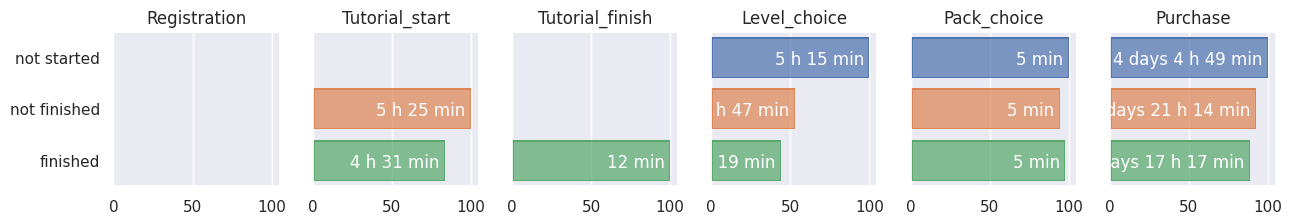

In [49]:
# Изучаем сиборн - часть 3. Интерфейс "объекты"!
fig = plt.figure(figsize=(15,2))
sns_so = \
(   so.Plot
    (   data = task_01_alt
        , y = 'tutorial_status'
        , x = 'percent_to_max'
        , color = 'tutorial_status'
        , text = 'interval_readable'
    )
    # .layout (size=(10,3))
    # .layout (size=(15,2))
    .facet (col='event')        #, wrap=3
    .label (x = None, y=None, color=None, title = str.capitalize)
    # .theme({**style.library["seaborn-v0_8"]})
    .add ( so.Bar () )
    .add ( so.Text (color='w', halign='right') )
    .on(fig)
)
sns_so.plot(pyplot=False)
fig.legends.pop(0);
# sns_so

# so.Bar ()     # также имеет дополнительные модификаторы:
# , so.Stack () / so.Dodge()

# Неожиданная особенность 1: 
# * so.Bar может быть в одном вызове .add()
# * so.Text надо прицеплять отдельным вызовом .add()

# Неожиданная особенность 2:
# выравнивание so.text работает странно. 
# right - выравнивает по правому краю внутри БАР-а
# left - по левому краю СНАРУЖИ БАР-а
# center - по центру, при этом центр - правый край БАР-а
# Да, это штатный режим работы. Объект so.Text призван добавлять аннотацию к ТОЧКЕ графика и в этом контексте такой режим работы смотрится довольно разумно.
# ТОЧКОЙ столбчатого графика считается конец столбца.


# https://stackoverflow.com/questions/73633322/how-can-i-customize-the-legend-with-seaborn-0-12-objects
# Нормального способа удалить легенду из этого в целом великолепного интерфейса пока не завезли.
# Поэтому придется таки немного заняться хер-ургией

# Ко собакам такое. Оформление херится, как в ебаном ворде. Выяснять, на каком этапе эта гавнина происходит - я слишком заебался.
# В чистовик подйет версия с легендой, но не расхуяченная


In [9]:
# plt.style.available

# Изучаем состав этого их объекта ПЛОТ
sns_so.__class__    # seaborn._core.plot.Plot
sns_so.__dict__.keys()
# '_data', '_layers', '_scales', '_shares', '_limits', '_labels', '_theme', 
# '_facet_spec', '_pair_spec', '_figure_spec', '_subplot_spec', '_layout_spec', '_target'

sns_so._data.__class__  # seaborn._core.data.PlotData
sns_so._data.__dict__.keys()        # 'frame', 'names', 'ids', 'frames', 'source_data', 'source_vars'
sns_so._data.ids            # {'y': 'tutorial_status', 'x': 'percent_to_max', 'text': 'interval_readable'}  # это то, что мы навыбирали для "маппинга" таблицы
sns_so._data.source_vars    # {'y': 'tutorial_status', 'x': 'percent_to_max', 'text': 'interval_readable'}  # хм, то же самое
sns_so._data.names          # {'y': 'tutorial_status', 'x': 'percent_to_max', 'text': 'interval_readable'}  # и тут оно же
sns_so._data.frames         # {}

sns_so._layers.__class__    # list
sns_so._layers.__len__()    # 2
sns_so._layers[0].__class__ # dict
sns_so._layers[0].keys()    # 'mark', 'stat', 'move', 'vars', 'source', 'legend', 'orient'
# (короче, 2 layers, у первого в mark - Bar, у второго Text)
# Откуда они такие? - похоже, это две сущности, добавленные мною через .add
# параметры Text похожи на те, что я задавал. Из параметров Bar ничего я не задавал. интересен там color=<'C0'> - очевидно означающий "цвет №0", 
# по которому распредлеяются палитры

# '_scales', '_shares', '_limits',      # пустые.
sns_so._labels      # {'title': <method 'capitalize' of 'str' objects>, 'y': None, 'color': None}   # ровно то, что я задавал
sns_so._figure_spec # {'figsize': (9, 3)}
sns_so._layout_spec # {}
sns_so._target.__class__    # NoneType

# Чего я не нашел - это выхода на матплотлибовские объекты

NoneType

In [10]:
plt.style.use('ggplot')

matplotlib.axes._axes.Axes

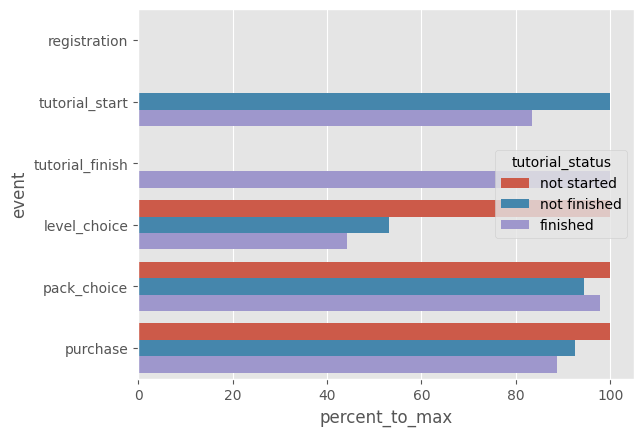

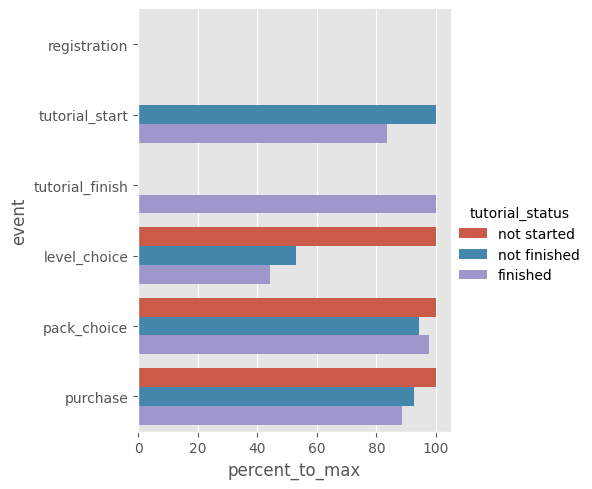

In [11]:
# fig_1, axes_1 = plt.subplots (nrows=1, ncols=2, figsize = (12,6), width_ratios=[1,3], sharey=True)
# Изучаем сиборн

# axes level

sns_axes = sns.barplot\
(   data = task_01_alt
    , y = 'event'
    , x = 'percent_to_max'
    , hue = 'tutorial_status'
    # , ax = axes[1]
)
sns_axes.__class__      # matplotlib.axes._axes.Axes
# Функция axes level возвращает матплотлибовский axes
# Ей можно передавать матплотлибовский axes, тогда вернет его же с врисованным внутрь графиком

sns_figure = sns.catplot\
(   data = task_01_alt
    , y = 'event'
    , x = 'percent_to_max'
    , hue = 'tutorial_status'
    , kind = 'bar'
)
sns_figure.__class__    # seaborn.axisgrid.FacetGrid
# Возвращает собственный сиборновский объект FacetGrid
# А попробуем-ка посмотреть, что у него есть
# sns_figure.__dict__.keys()      # все на _. Т.е. то, счем мы можем работать - по сути ПРОПЕРТИС
# sns_figure.figure.__class__     # matplotlib.figure.Figure      # возвращает И ПОКАЗЫВАЕТ матплотлибовский Figure, стоящий за этим
sns_figure.axes.__class__   # numpy.ndarray
sns_figure.axes.shape   # (1, 1)
sns_figure.axes[0,0].__class__  # matplotlib.axes._axes.Axes





In [12]:
max_time_per_event = \
(   task_01_alt
    .groupby('event', as_index=False)['interval'].max()
    .assign
    (**{'interval_readable': lambda df:
        df['interval'].dropna().map (lambda x: make_timedelta_readable(x))
    })
    .set_index('event')
    ['interval_readable']
    .fillna('-')
)
max_time_per_event#['purchase']

event
registration                         -
tutorial_start            5 hrs 25 min
tutorial_finish           0 hrs 12 min
level_choice              5 hrs 15 min
pack_choice                0 hrs 5 min
purchase           4 days 4 hrs 49 min
Name: interval_readable, dtype: object

In [13]:
sns_so = so.Plot\
(   data = task_01_alt
    , 
)

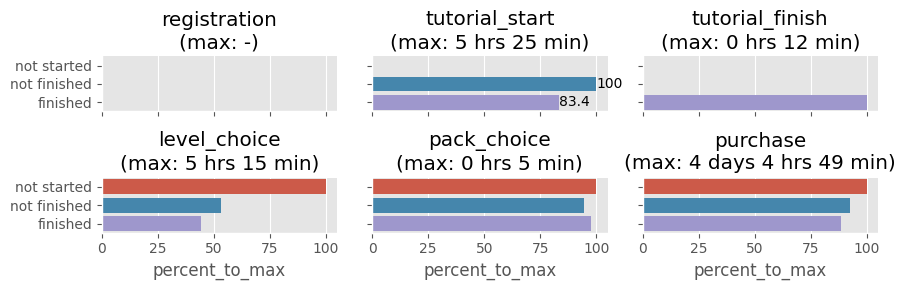

In [14]:
sns_figure = \
(   sns.catplot
    (   data = task_01_alt
        , kind = 'bar'
        , col = 'event', col_wrap=3
        , y = 'tutorial_status', x = 'percent_to_max'
        # , hue = 'tutorial_status'
        , height = 1.5, aspect = 2, dodge = False
        # , sharey = False
    )
    .set_ylabels  ('')
    # .set_titles   ("{col_name}")
    # .set_yticklabels  (label=None)
)                   # О, sns поддерживает мой любимый чейнинг (обо что я сильно спотыкался в "голом" матплотлибе)


for (i, ax) in enumerate(sns_figure.axes.flat):
    col_name = sns_figure.col_names[i]
    ax.set_title (f"{col_name}\n(max: {max_time_per_event[col_name]})")

sns_figure.axes[1].bar_label(sns_figure.axes[1].containers[0])

# Пробуем пририсовать 


sns_figure.tight_layout()

In [15]:
sns_figure.axes[3]      # <Axes: title={'center': 'level_choice\n(max: 5 hrs 15 min)'}, xlabel='percent_to_max'>
sns_figure.axes[3].containers[0].datavalues     # array([100. ,  53.1,  44.3])
sns_figure.axes[3].yaxis    # <matplotlib.axis.YAxis at 0x1c06edbc190>
sns_figure.axes[3].ylabels()

AttributeError: 'Axes' object has no attribute 'ylabels'

In [ ]:
# Первично изучаем тему "контейнеров"

ax = sns_figure.axes[1]
print(f"ax.containers"
    f"\n\t__class__:\t{ax.containers.__class__}"
    f"\n\t__len()__:\t{ax.containers.__len__()}"
)
print(f"ax.containers[0]"
    f"\n\t__class__:\t{ax.containers[0].__class__}"     # matplotlib.container.BarContainer
    f"\n\t__dict__:\t{ax.containers[0].__dict__.keys()}"
    f"\n\t_label:\t{ax.containers[0]._label}"
    f"\n\tget_label():\t{ax.containers[0].get_label()}"     # _container0   # Довольно неожиданно, что он безымянный. Потом проверить на сложном графике
    f"\n\torientation:\t{ax.containers[0].orientation}"     # horizontal    # интересное
    f"\n\tstale:\t{ax.containers[0].stale}"                 # True          # этого в справке нет
)
print(f"ax.containers[0].datavalues"
    f"\n\t__class__:\t{ax.containers[0].datavalues.__class__}"
    f"\n\t__len()__:\t{ax.containers[0].datavalues.__len__()}"
    f"\n\tself:\t{ax.containers[0].datavalues}"     # [  nan 100.   83.4]   # т.е. это наш второй график.
)

print(f"ax.containers[0].patches"
    f"\n\t__class__:\t{ax.containers[0].patches.__class__}"
    f"\n\t__len()__:\t{ax.containers[0].patches.__len__()}"
    f"\n\tself:\t{ax.containers[0].patches}"     # [<matplotlib.patches.Rectangle object at ... # конечные прямоугольнички
)

ax.containers
	__class__:	<class 'list'>
	__len()__:	1
ax.containers[0]
	__class__:	<class 'matplotlib.container.BarContainer'>
	__dict__:	dict_keys(['patches', 'errorbar', 'datavalues', 'orientation', '_callbacks', '_remove_method', '_label', 'stale'])
	_label:	_container0
	get_label():	_container0
	orientation:	horizontal
	stale:	True
ax.containers[0].datavalues
	__class__:	<class 'numpy.ndarray'>
	__len()__:	3
	self:	[  nan 100.   83.4]
ax.containers[0].patches
	__class__:	<class 'list'>
	__len()__:	3
	self:	[<matplotlib.patches.Rectangle object at 0x000001C06D4737D0>, <matplotlib.patches.Rectangle object at 0x000001C06D44EF10>, <matplotlib.patches.Rectangle object at 0x000001C06C65E210>]


In [ ]:
# Изучаем axes и col_var

[x for x in sns_figure.axes]
# [<Axes: title={'center': 'registration'}>,
#  <Axes: title={'center': 'tutorial_start'}>,
#  <Axes: title={'center': 'tutorial_finish'}>,
#  <Axes: title={'center': 'level_choice'}, xlabel='percent_to_max'>,
#  <Axes: title={'center': 'pack_choice'}, xlabel='percent_to_max'>,
#  <Axes: title={'center': 'purchase'}, xlabel='percent_to_max'>]

# Т.е. а) у объекта Axes есть title (что хорошо) б) у него есть хитровыеманая стуктура
# [x for x in sns_figure.col_names]
# ['registration',
#  'tutorial_start',
#  'tutorial_finish',
#  'level_choice',
#  'pack_choice',
#  'purchase']

sns_figure._col_var # event

sns_figure.axes.__class__   # numpy.ndarray
sns_figure.axes.shape       # (6,)

sns_figure.axes.flat.__class__  # numpy.flatiter

numpy.flatiter

In [ ]:
item_1 = 'item_1 contents'

dic = dict(item_1 = item_1)
dic # {'item_1': 'item_1 contents'}

{'item_1': 'item_1 contents'}

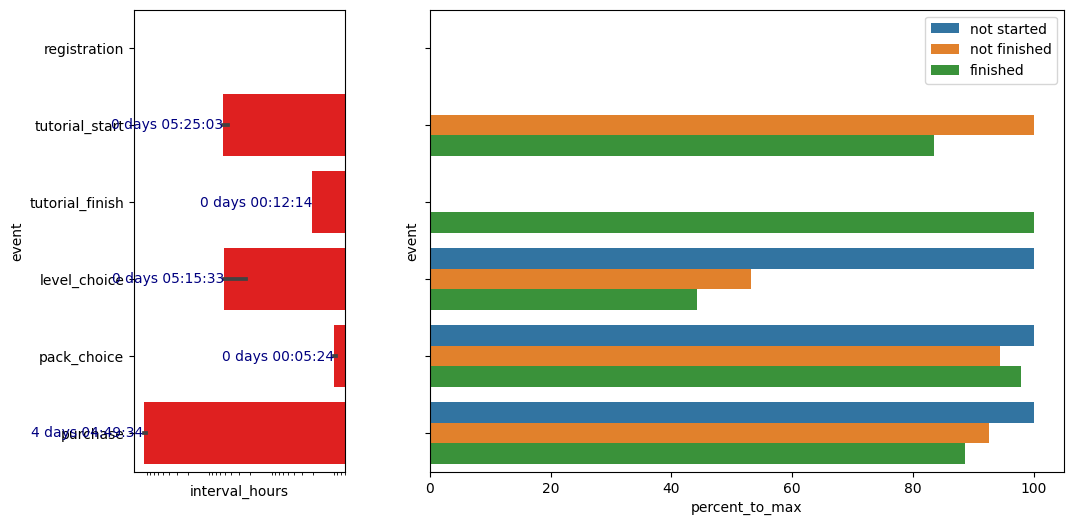

In [ ]:
fig, axes = plt.subplots (nrows=1, ncols=2, figsize = (12,6), width_ratios=[1,3], sharey=True)


right = sns.barplot\
(   data = task_01_alt
    , y = 'event'
    , x = 'percent_to_max'
    , hue = 'tutorial_status'
    , ax = axes[1]
)
axes[0].invert_xaxis()
left = sns.barplot\
(   data = task_01_alt.dropna()
    , y = 'event'
    , x = 'interval_hours'
    , ax = axes[0]
    , estimator = 'max',
    color = 'red'
)
axes[0].set_xscale('log')
axes[0].set_xticks([])
axes[1].legend (loc='upper right');      # матплотлиб работает "процедурно"
# axes[0].set_ylabels (task_01_alt.groupby('event')['interval'].max().round('1s'))
axes[0].bar_label\
(   axes[0].containers[0]
    , task_01_alt.groupby('event')['interval'].max().round('1s')
    , color = 'navy'
);

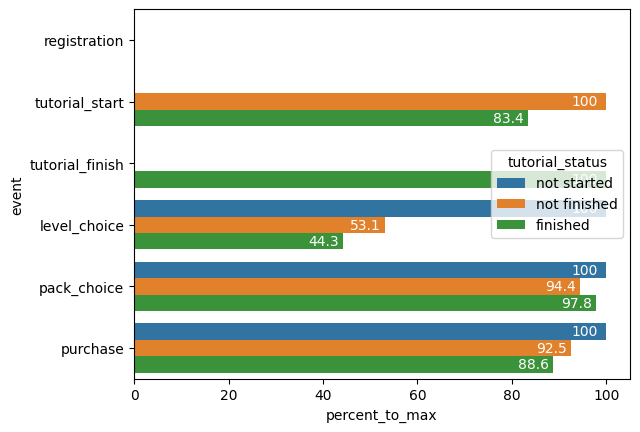

In [ ]:
b = sns.barplot\
(   data = task_01_alt
    , y = 'event'
    , x = 'percent_to_max'
    , hue = 'tutorial_status'
)


b.__class__     # matplotlib.axes._axes.Axes
# sns.barplot возвращает объект matplotlib.axes
# у этого объекта есть свойство containers
b.containers.__class__  # list
b.containers.__len__ () # 3
# containers моего графика представляет собой список из 3 элементов (соответствуют числу ПАРАМЕТРОВ в моей классификации)
b.containers[0]         # <BarContainer object of 6 artists>
b.containers[0].__class__   # matplotlib.container.BarContainer
# каждый container включает в себя 6 (по числу записей) "рисовальщиков"
b.containers[2].datavalues
# array([  nan,  83.4, 100. ,  44.3,  97.8,  88.6])
b.containers[2].get_label() # 'finished'

for c in b.containers:
    b.bar_label (c, label_type = 'edge', padding = -25, color = 'white')






# b.bar_label ()
# b.__class__ # matplotlib.axes._axes.Axes


<Axes: ylabel='event'>

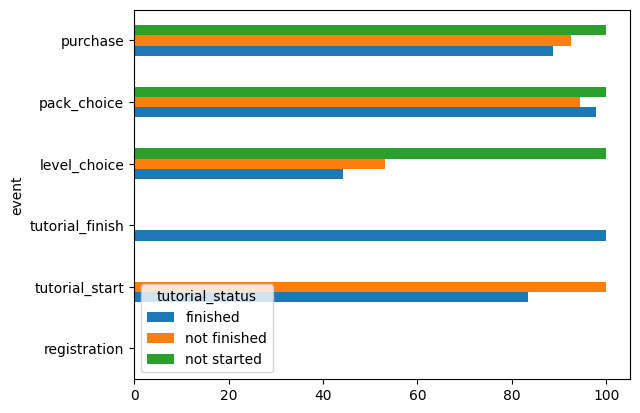

In [ ]:
c = \
(   task_01_alt[['event', 'tutorial_status', 'percent_to_max']]
    .set_index (['event', 'tutorial_status'])
    .unstack ('tutorial_status')
    .sort_index(ascending = False, axis = 1)
    .plot
    (   kind = 'barh'
        , y = 'percent_to_max'
        , stacked = False
    )
)
c

In [ ]:
def humanize_headers (df):
    df.columns = \
    (   df.columns
        .str.replace('_',' ')
        .str.split(':')
        .map(lambda x:x[1])
    )
    return df
plot_01 = \
(task_01
    # .fillna (pd.to_timedelta(0))
    .applymap (lambda x: x.days*24 + x.seconds/3600).round(2)
    .apply (lambda x: x/x.sum())
    .pipe (humanize_headers)
    .transpose()
    .rename_axis(columns=None, index='event')
    .reset_index()
    # .plot(kind = 'barh')
)
plot_01

,event,not started,not finished,finished
0,tutorial start,NaN,0.545272,0.454728
1,tutorial finish,NaN,NaN,1.000000
2,level choice,0.506744,0.268786,0.224470
3,pack choice,0.346154,0.307692,0.346154
4,purchase,0.355812,0.329063,0.315125


''

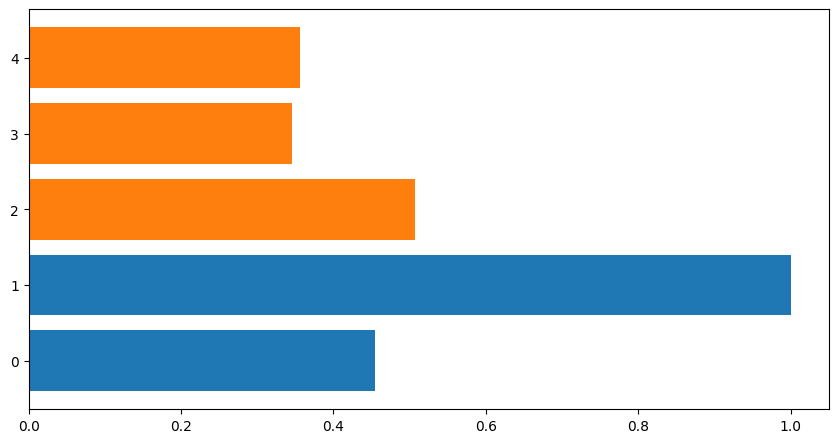

In [ ]:
fig = plt.figure (figsize=(8,4))
axes = fig.add_axes ([0,0,1,1])



axes.barh\
(   y = plot_01.index, width=plot_01['finished']
)
axes.barh\
(   y = plot_01.index, width=plot_01['not started']
)
;